In [1]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import einops
from einops.layers.torch import Rearrange


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

data_dir = "dataset"

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = test_transform = transforms.ToTensor()
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m - m * 0.2), int(m * 0.2)])
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


Selected device: cuda


In [49]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=0),  # 1x28x28 -> 32x12x12
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0),  # 32x12x12 -> 64x4x4
            nn.ReLU(),
            Rearrange("b c h w -> b (c h w)"),
            nn.Linear(64 * 4 * 4, 64 * 4 * 4),
            nn.ReLU(),
            nn.Linear(64 * 4 * 4, 64 * 4 * 4),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.LazyLinear(latent_dims),
        )
        self.log_var = nn.Sequential(
            nn.LazyLinear(latent_dims),
            nn.ReLU(),
        )

    def sample(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        esp = torch.randn(*std.size()).to(device)
        z = mu + std * esp
        return z

    def forward(self, x):
        x = x.to(device)
        x = self.main_block(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.sample(mu, log_var)
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Linear(latent_dims, 64 * 4 * 4),
            nn.ReLU(),
            nn.Linear(64 * 4 * 4, 64 * 4 * 4),
            nn.ReLU(),
            Rearrange("b (c h w) -> b c h w", c=64, h=4, w=4),
            nn.ConvTranspose2d(
                64, 32, 5, stride=2, output_padding=1
            ),  # 64x4x4 -> 32x12x12
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 1, 5, stride=2, output_padding=1
            ),  # 32x12x12 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.to(device)
        return self.main_block(x)


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), z, mu, log_var


In [50]:
### Set the random seed for reproducible results
torch.manual_seed(0)

latent_dims = 10
vae = VariationalAutoencoder(latent_dims=latent_dims)

lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)


VariationalAutoencoder(
  (encoder): Encoder(
    (main_block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (3): ReLU()
      (4): Rearrange('b c h w -> b (c h w)')
      (5): Linear(in_features=1024, out_features=1024, bias=True)
      (6): ReLU()
      (7): Linear(in_features=1024, out_features=1024, bias=True)
      (8): ReLU()
    )
    (mu): Sequential(
      (0): LazyLinear(in_features=0, out_features=10, bias=True)
    )
    (log_var): Sequential(
      (0): LazyLinear(in_features=0, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Decoder(
    (main_block): Sequential(
      (0): Linear(in_features=10, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
      (4): Rearrange('b (c h w) -> b c h w', c=64, h=4, w=4)
      (5): ConvTranspose2d(64, 32, kernel_size=(5, 5), s

In [51]:
def loss_function(x_hat, x, mu, log_var):
    bce = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kl


def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat, _, mu, log_var = vae(x)
        loss = loss_function(x_hat, x, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)


def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():  # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            x_hat, _, mu, log_var = vae(x)
            loss = loss_function(x_hat, x, mu, log_var)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)


def plot_ae_outputs(vae, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        vae.eval()
        with torch.no_grad():
            x_hat, _, _, _ = vae(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_hat.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Reconstructed images")
    plt.show()


Beginning training


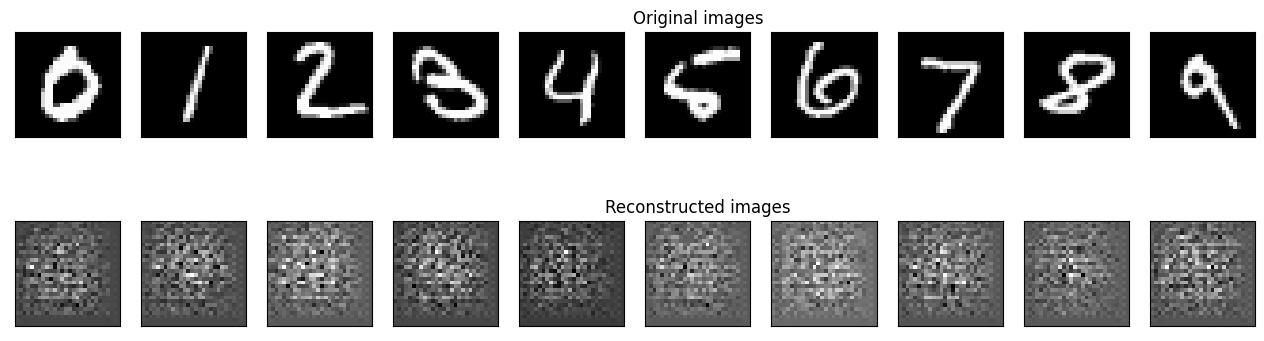


 EPOCH 1/500 	 train loss 294.891 	 val loss 255.065


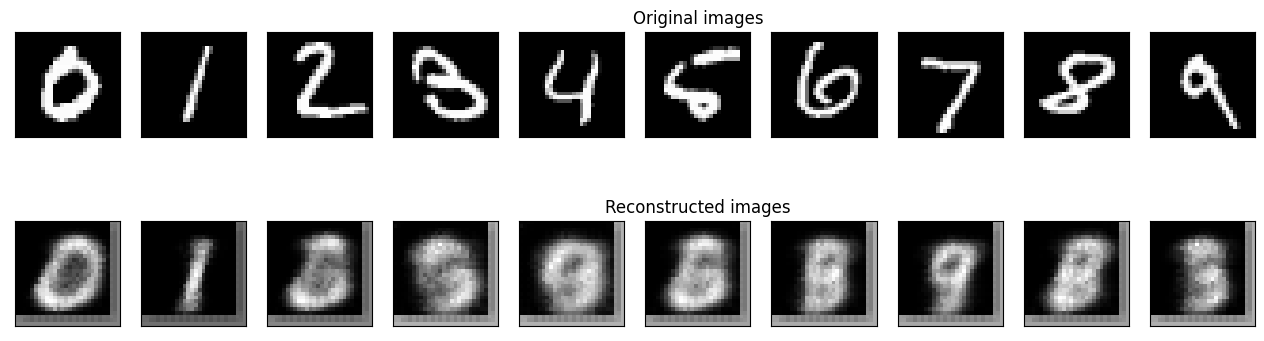


 EPOCH 2/500 	 train loss 219.651 	 val loss 196.860


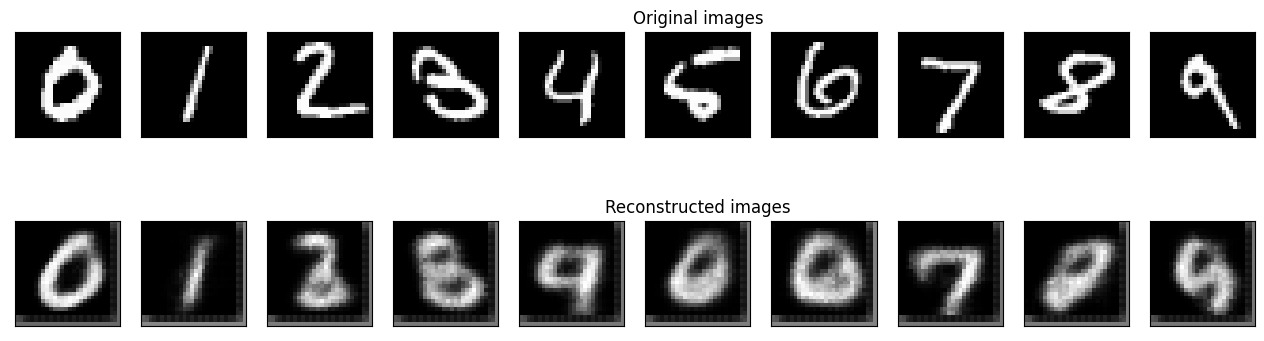


 EPOCH 3/500 	 train loss 188.861 	 val loss 184.182


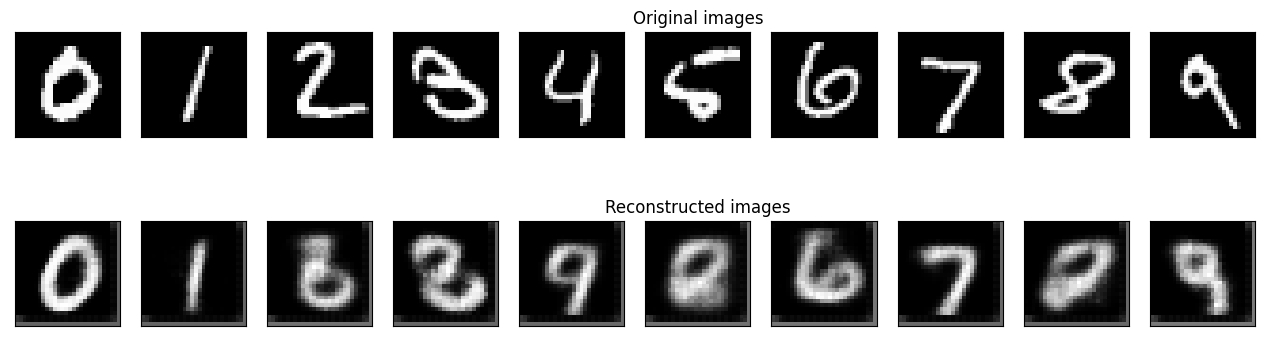


 EPOCH 4/500 	 train loss 179.437 	 val loss 176.375


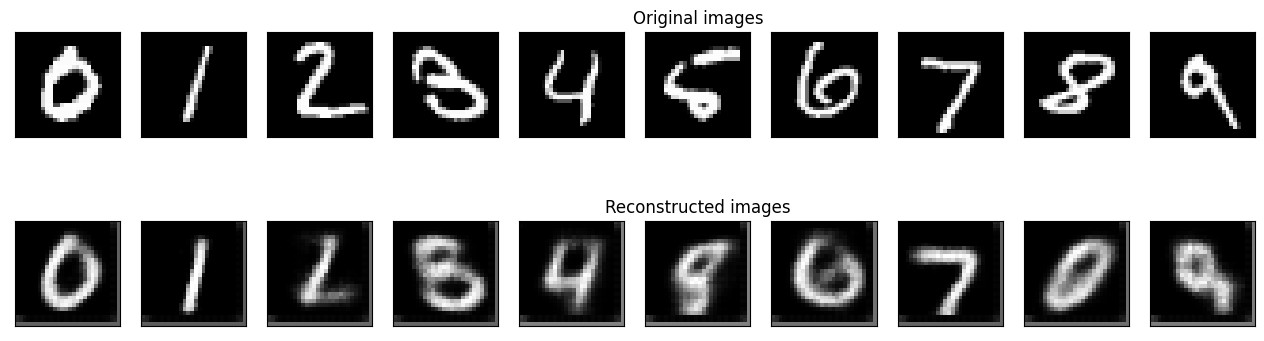


 EPOCH 5/500 	 train loss 173.279 	 val loss 171.135


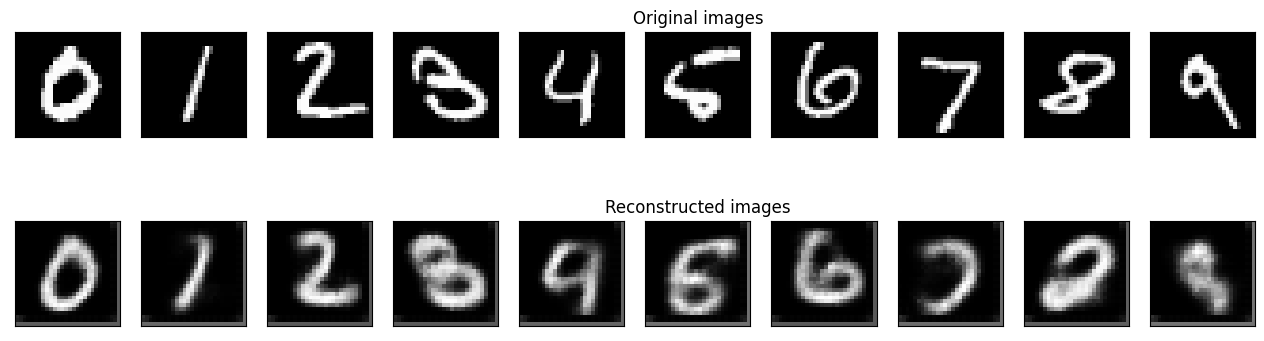


 EPOCH 6/500 	 train loss 168.632 	 val loss 167.411


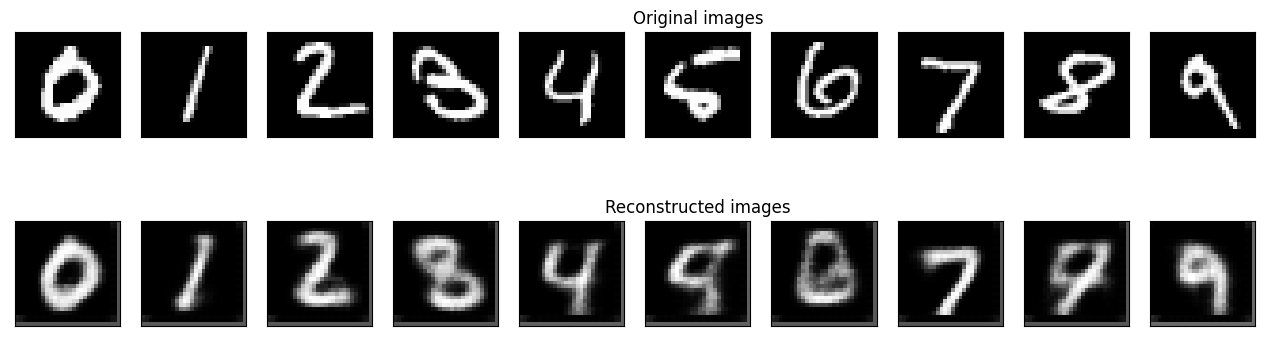


 EPOCH 7/500 	 train loss 165.473 	 val loss 164.591


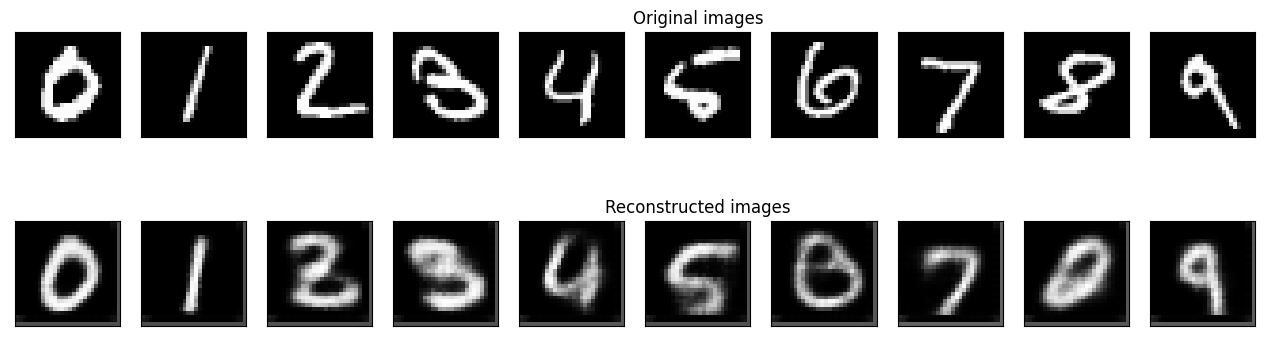


 EPOCH 8/500 	 train loss 162.802 	 val loss 162.380


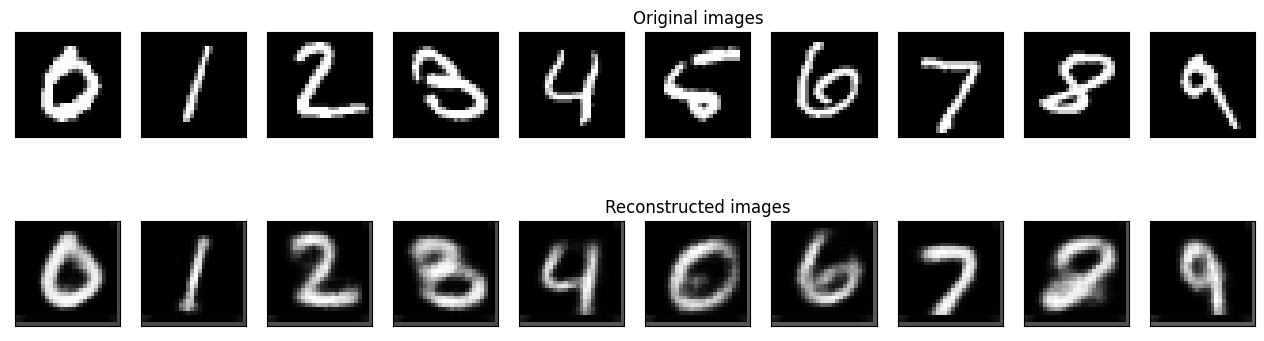


 EPOCH 9/500 	 train loss 160.433 	 val loss 160.123


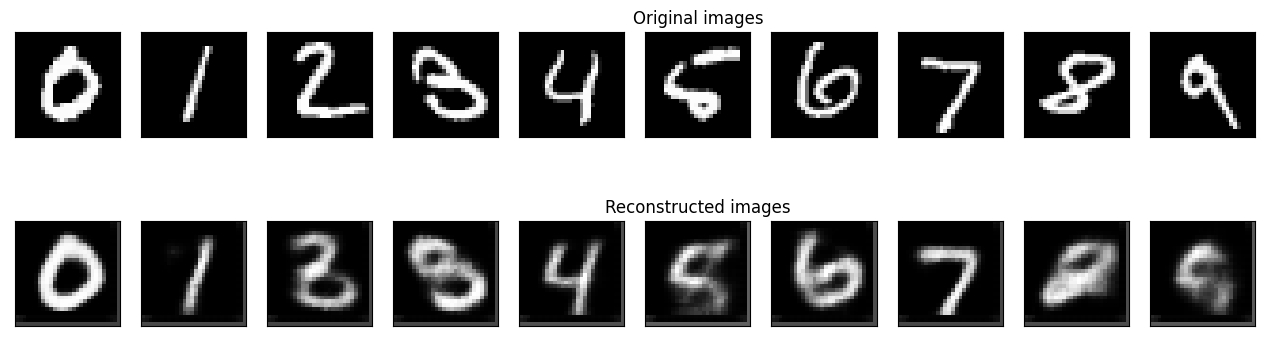


 EPOCH 10/500 	 train loss 158.345 	 val loss 158.264


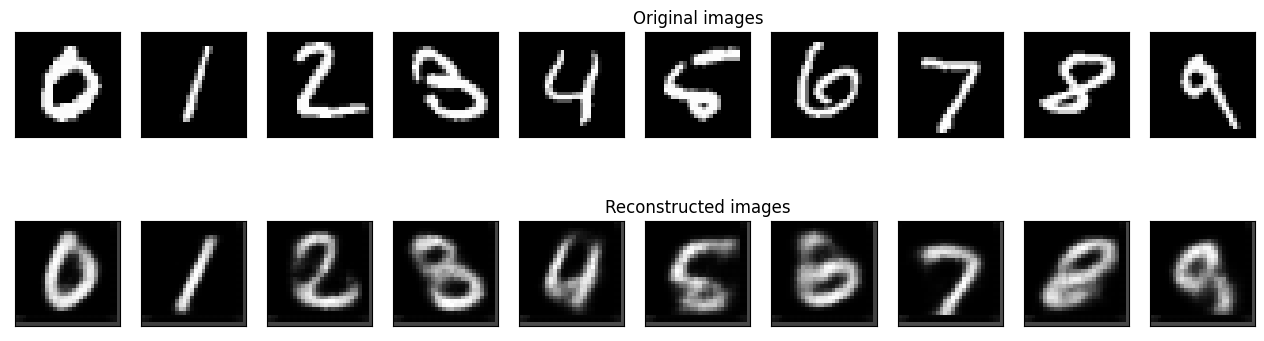


 EPOCH 11/500 	 train loss 156.687 	 val loss 156.684


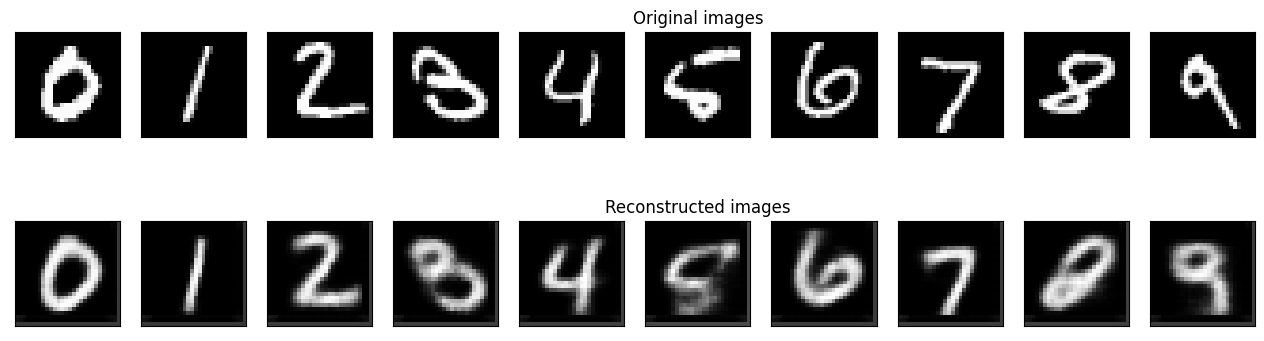


 EPOCH 12/500 	 train loss 154.823 	 val loss 154.428


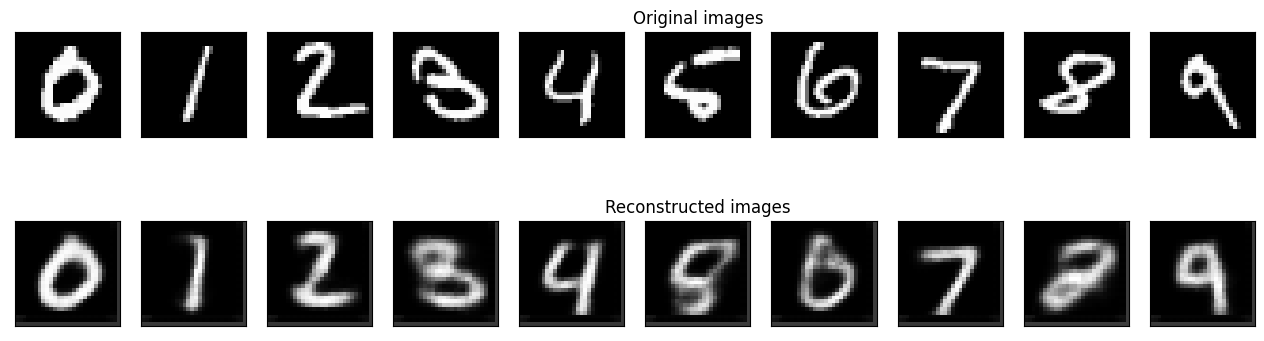


 EPOCH 13/500 	 train loss 153.245 	 val loss 153.532


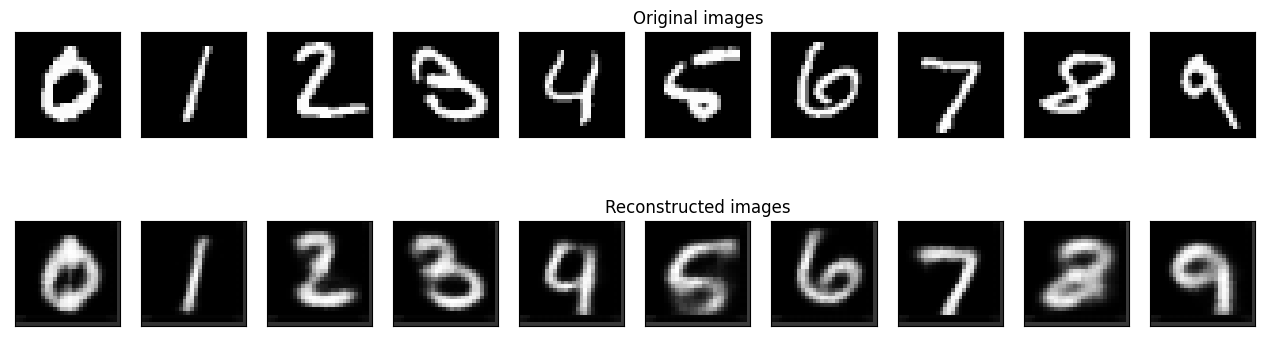


 EPOCH 14/500 	 train loss 152.073 	 val loss 152.542


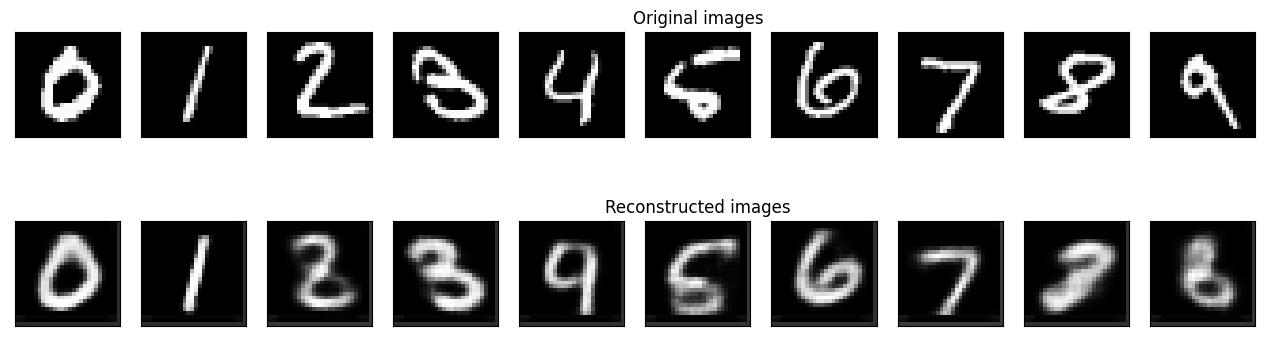


 EPOCH 15/500 	 train loss 150.670 	 val loss 151.046


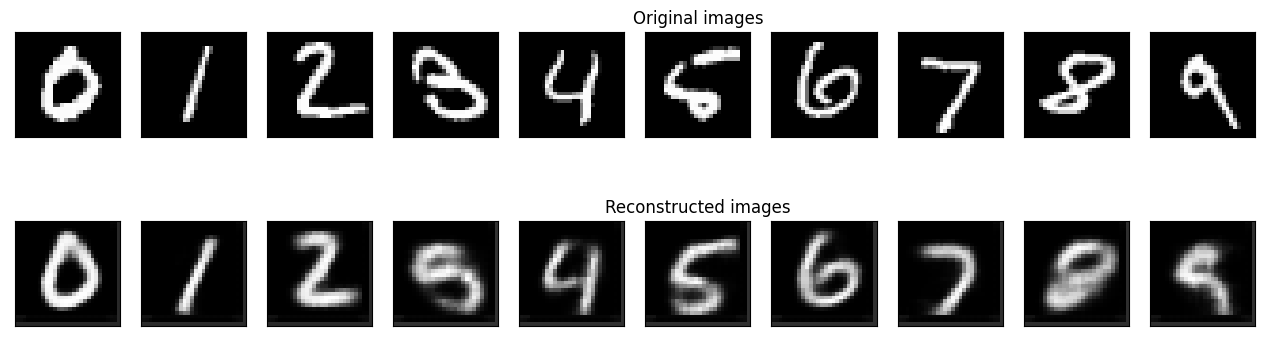


 EPOCH 16/500 	 train loss 149.840 	 val loss 150.729


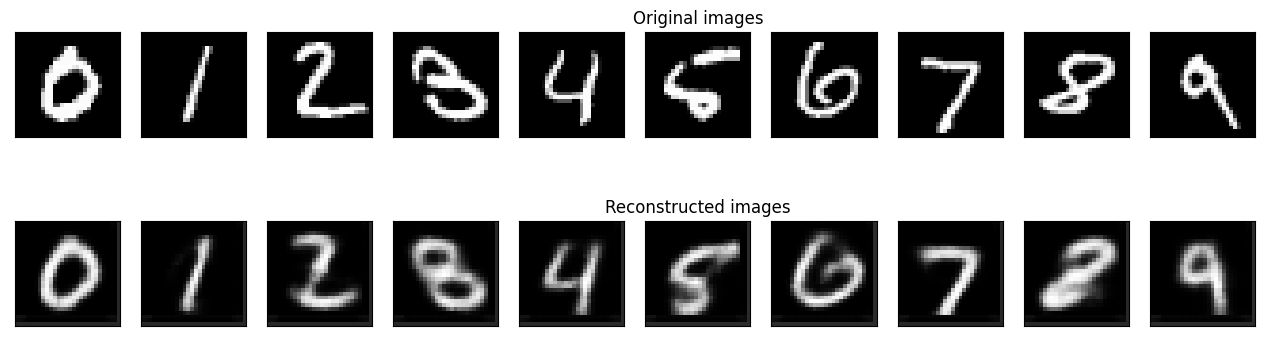


 EPOCH 17/500 	 train loss 148.698 	 val loss 148.784


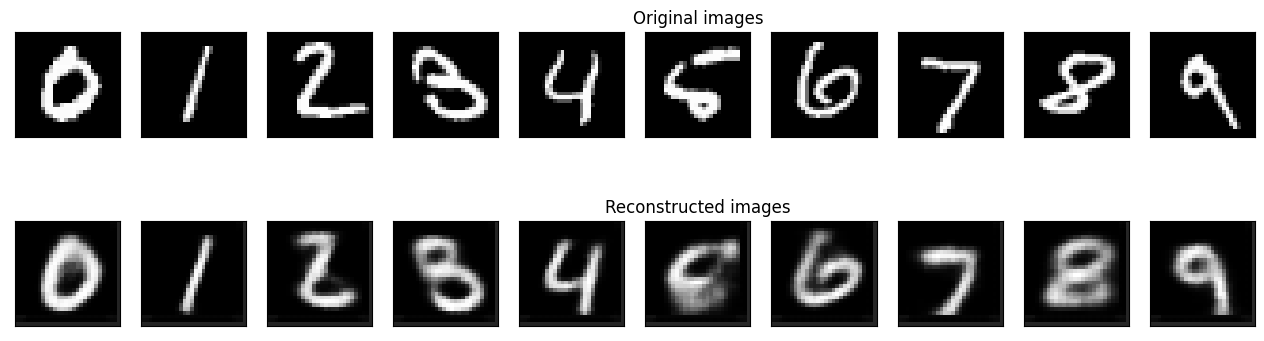


 EPOCH 18/500 	 train loss 147.863 	 val loss 148.586


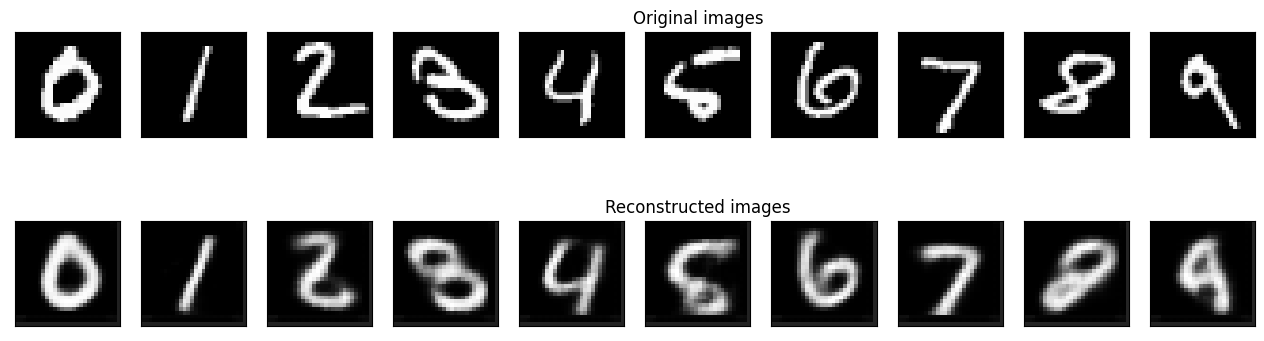


 EPOCH 19/500 	 train loss 146.970 	 val loss 147.261


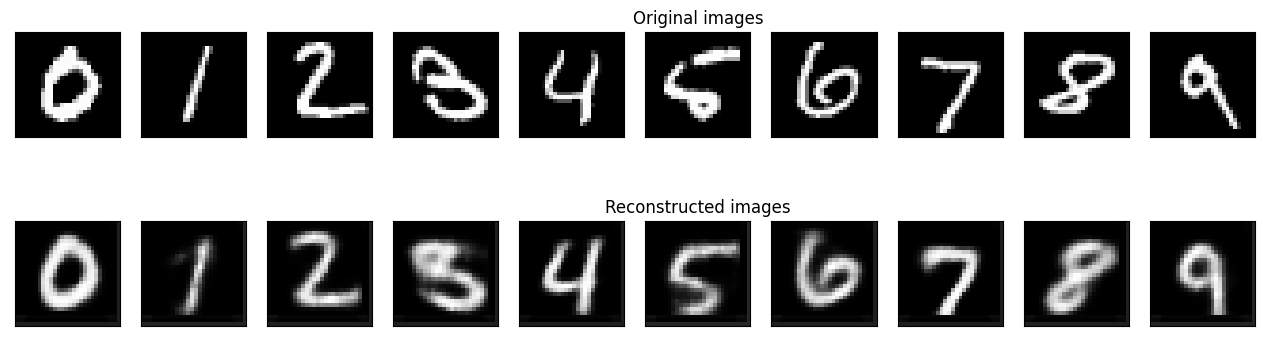


 EPOCH 20/500 	 train loss 146.211 	 val loss 147.562


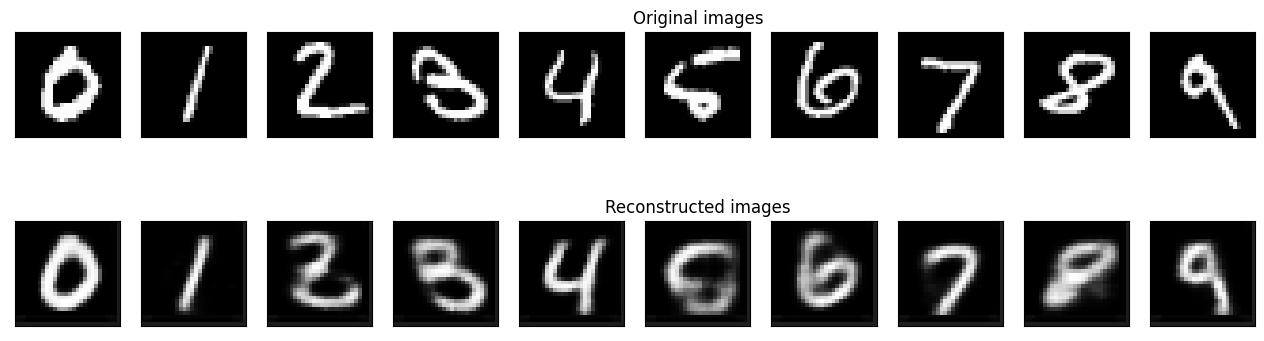


 EPOCH 21/500 	 train loss 145.470 	 val loss 146.335


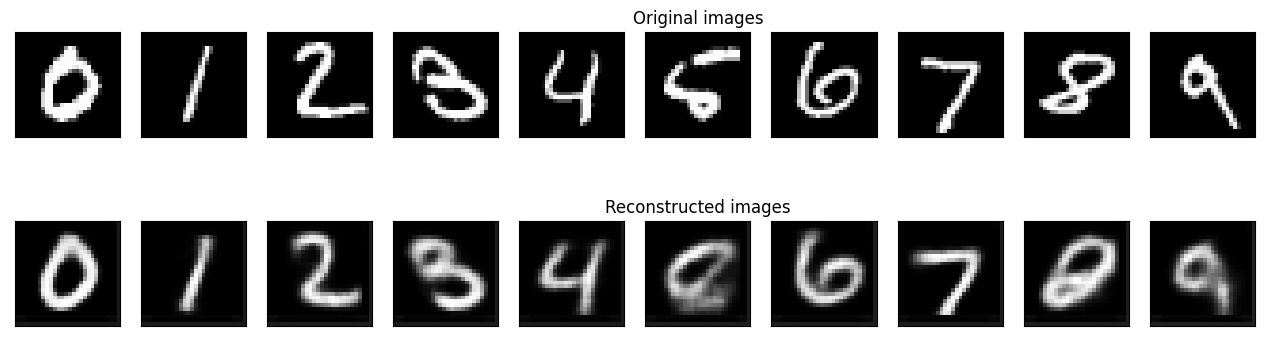


 EPOCH 22/500 	 train loss 144.851 	 val loss 145.325


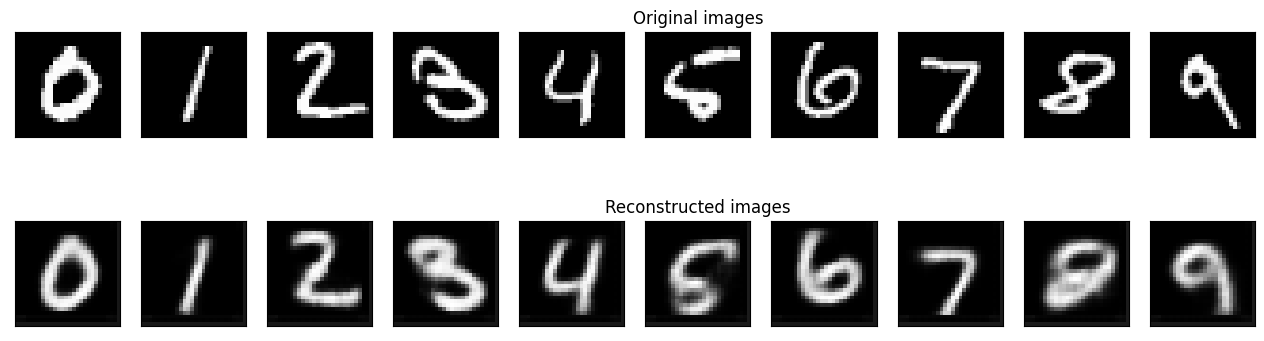


 EPOCH 23/500 	 train loss 144.145 	 val loss 145.112


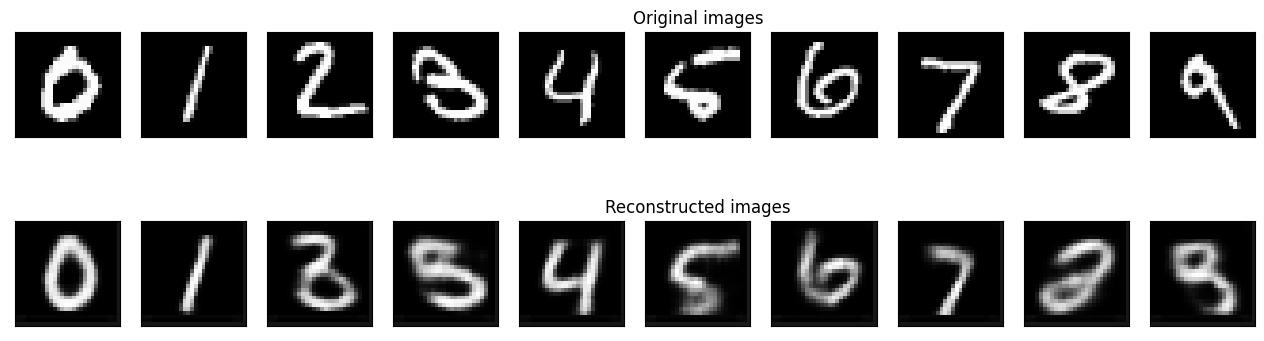


 EPOCH 24/500 	 train loss 143.542 	 val loss 144.362


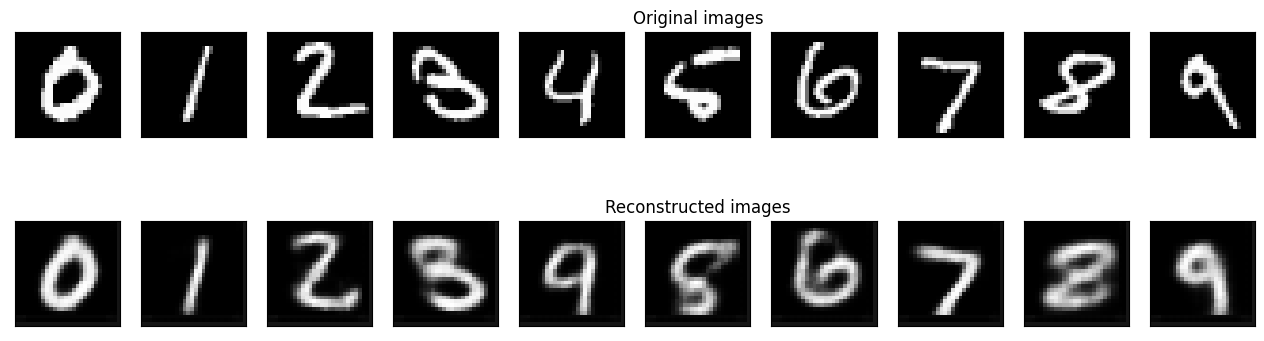


 EPOCH 25/500 	 train loss 143.165 	 val loss 143.887


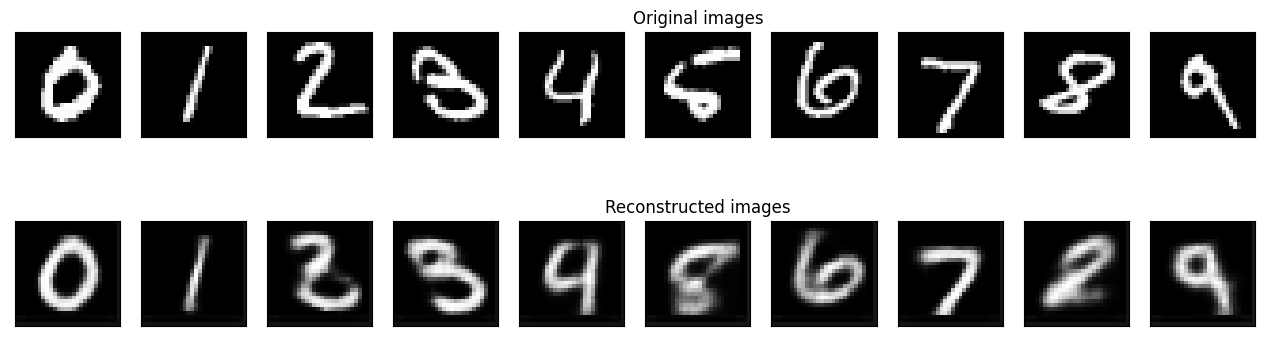


 EPOCH 26/500 	 train loss 142.682 	 val loss 143.473


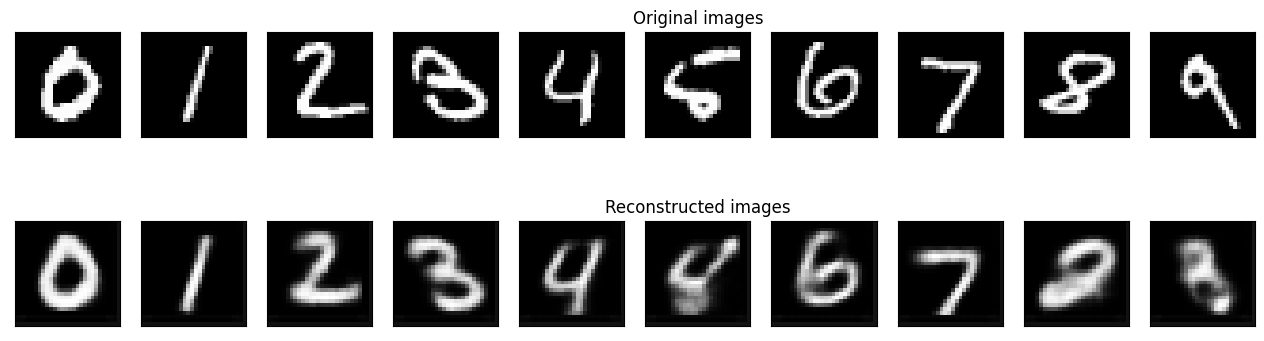


 EPOCH 27/500 	 train loss 142.458 	 val loss 143.047


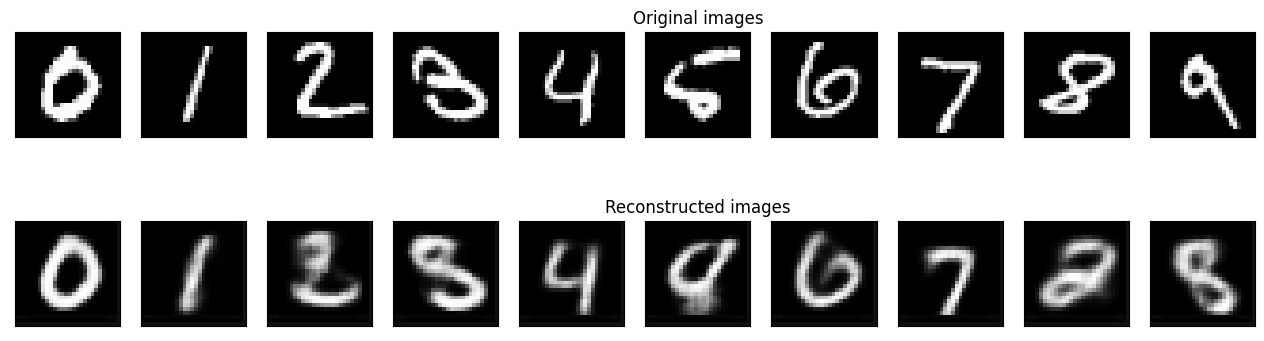


 EPOCH 28/500 	 train loss 141.931 	 val loss 142.727


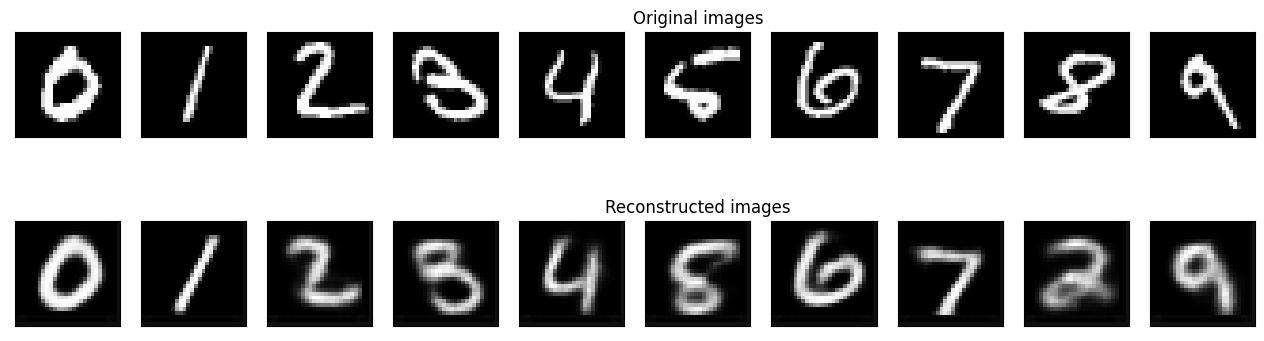


 EPOCH 29/500 	 train loss 141.599 	 val loss 142.482


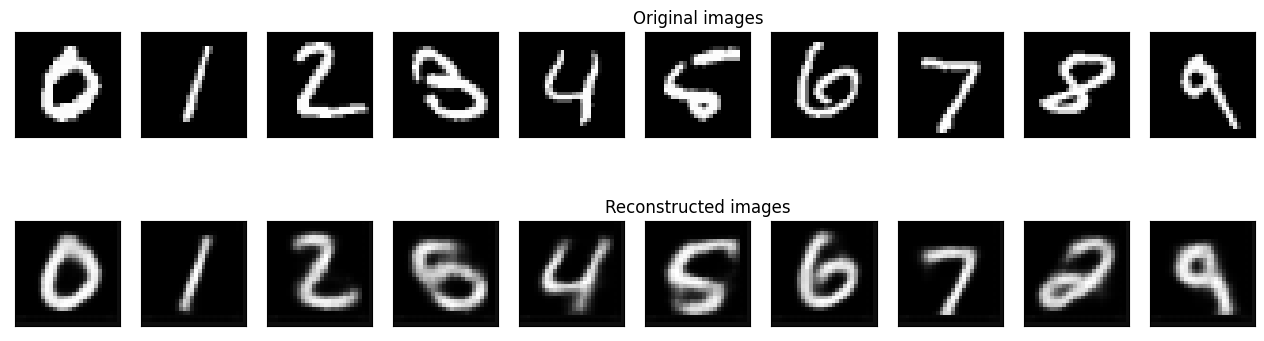


 EPOCH 30/500 	 train loss 141.326 	 val loss 142.524


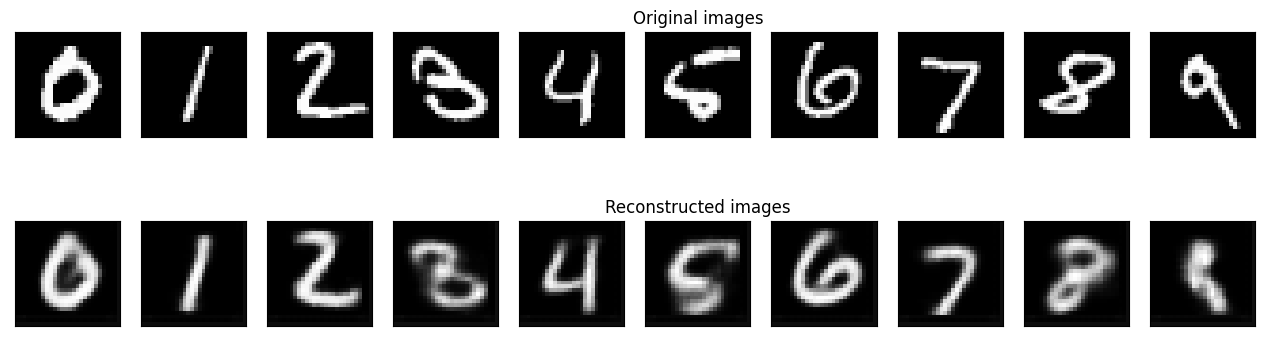


 EPOCH 31/500 	 train loss 140.912 	 val loss 141.625


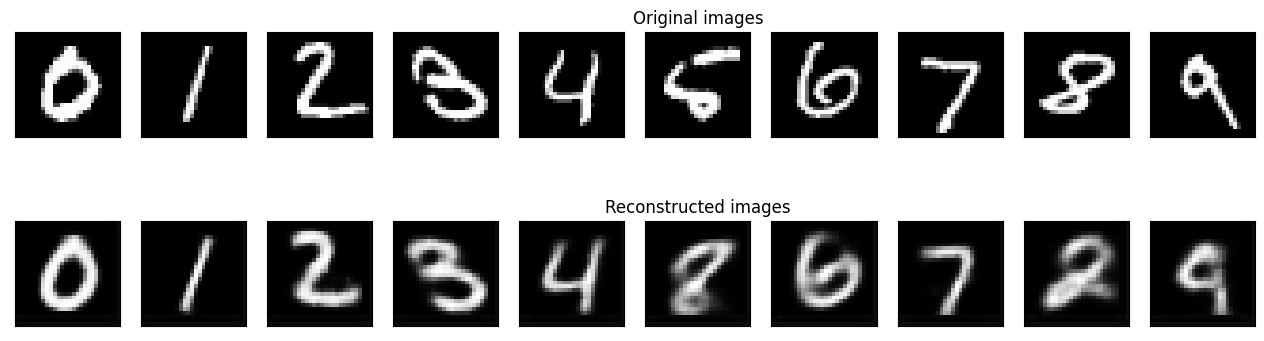


 EPOCH 32/500 	 train loss 140.772 	 val loss 141.098


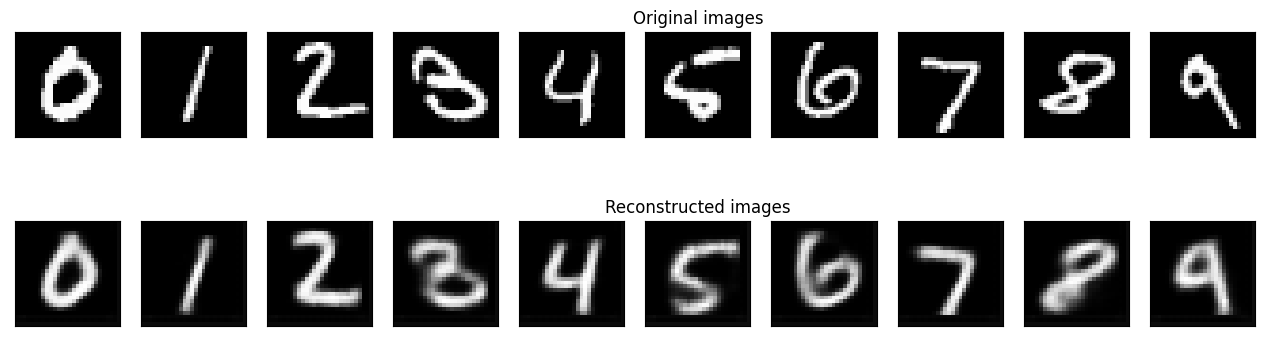


 EPOCH 33/500 	 train loss 140.374 	 val loss 141.306


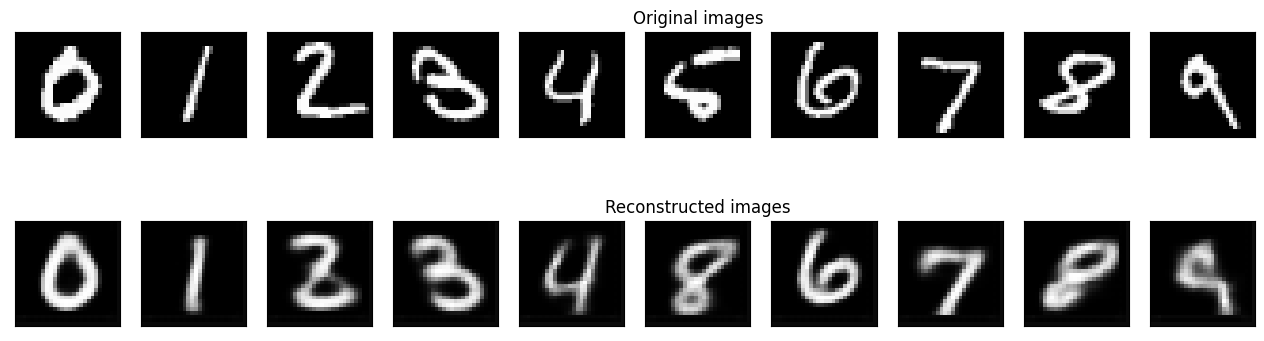


 EPOCH 34/500 	 train loss 140.189 	 val loss 141.163


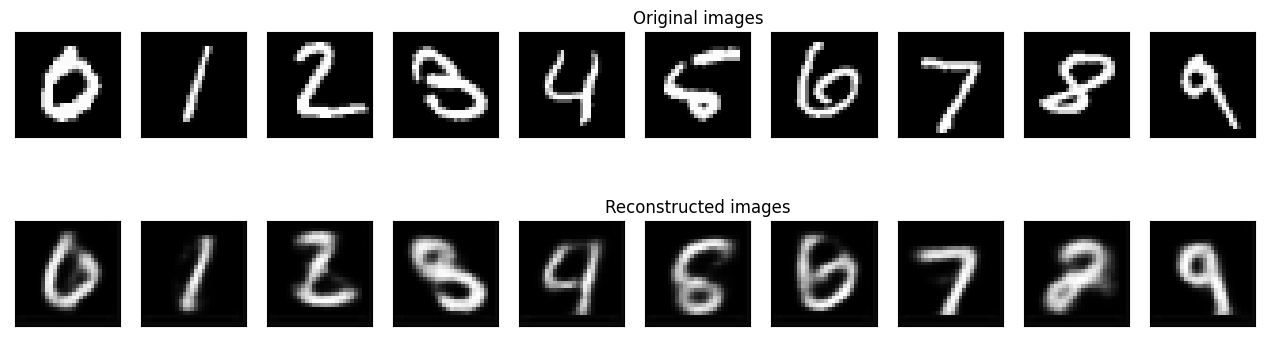


 EPOCH 35/500 	 train loss 139.936 	 val loss 141.068


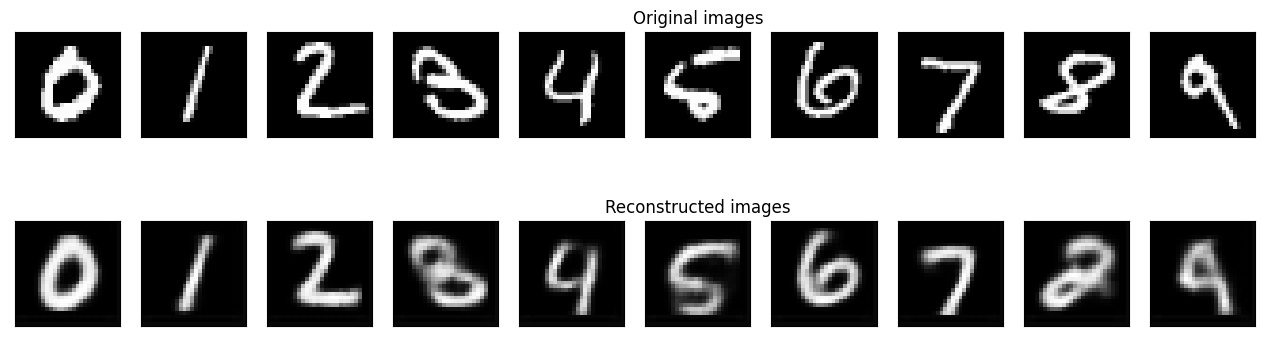


 EPOCH 36/500 	 train loss 139.833 	 val loss 140.418


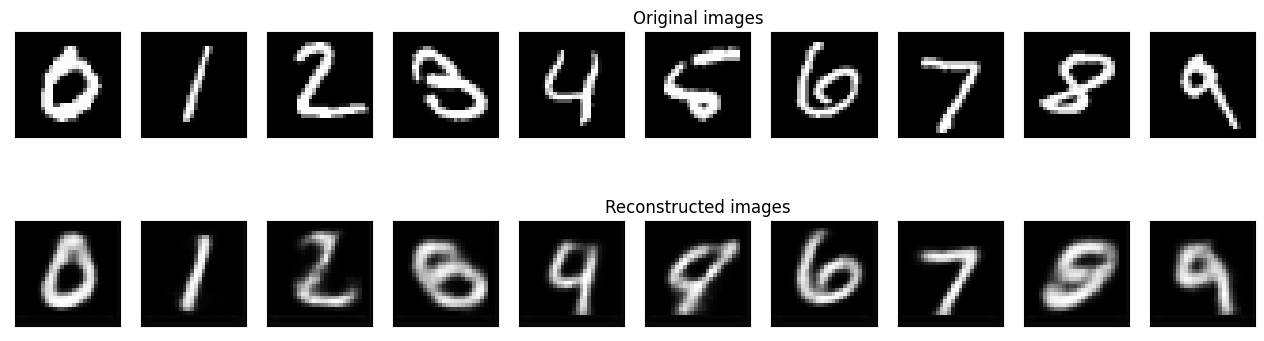


 EPOCH 37/500 	 train loss 139.673 	 val loss 140.366


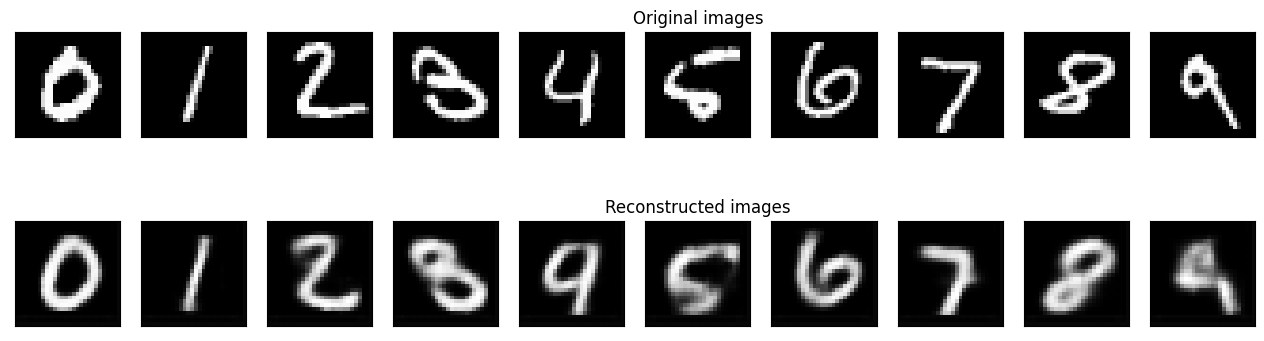


 EPOCH 38/500 	 train loss 139.407 	 val loss 140.595


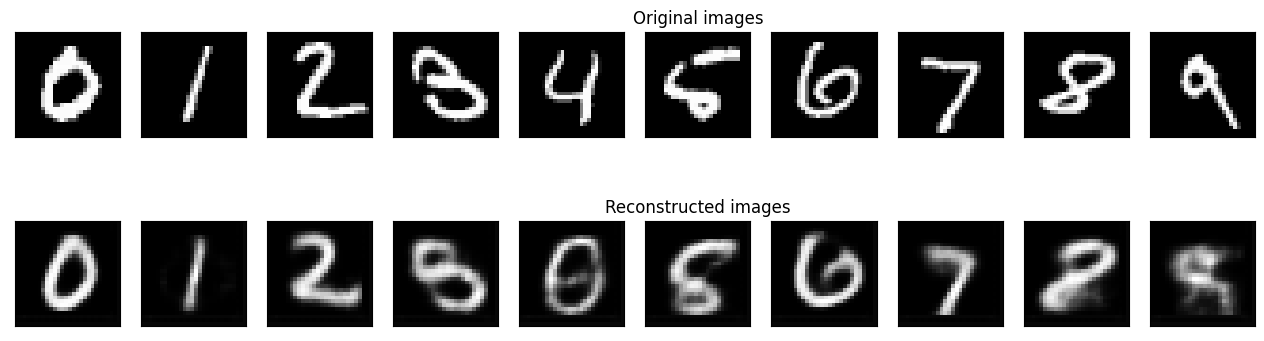


 EPOCH 39/500 	 train loss 139.298 	 val loss 139.941


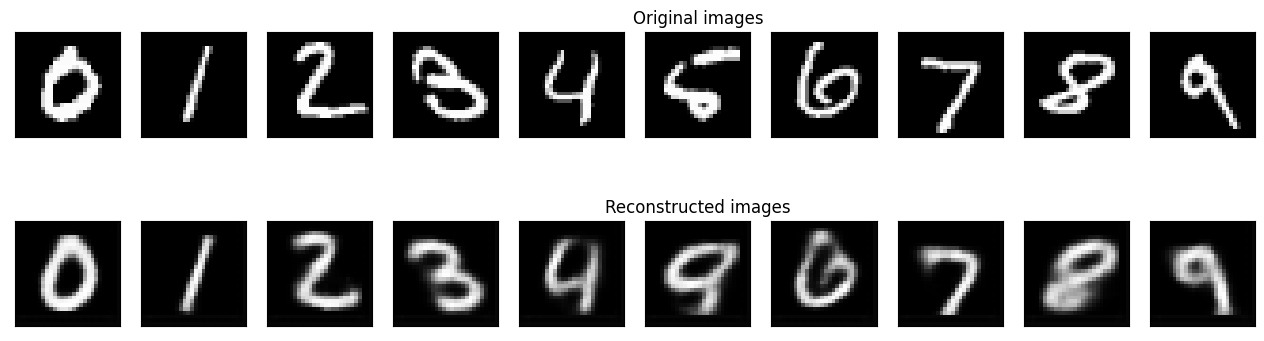


 EPOCH 40/500 	 train loss 139.202 	 val loss 140.092


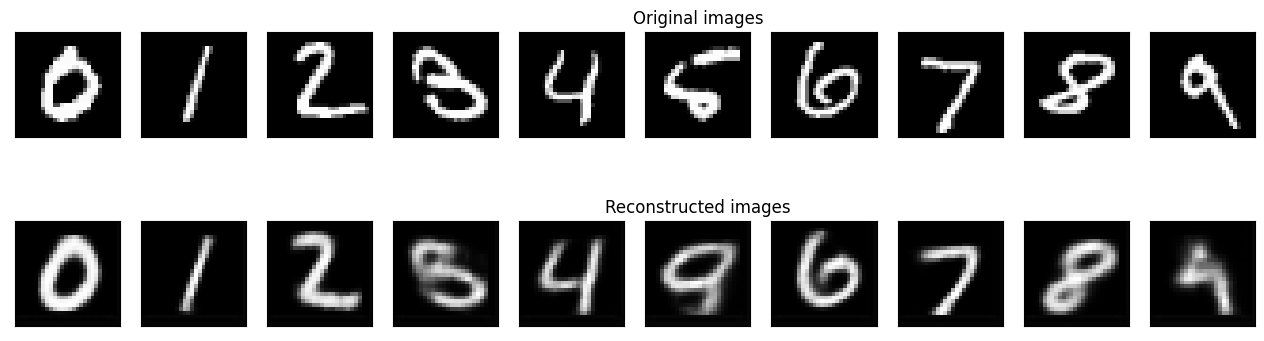


 EPOCH 41/500 	 train loss 138.976 	 val loss 139.756


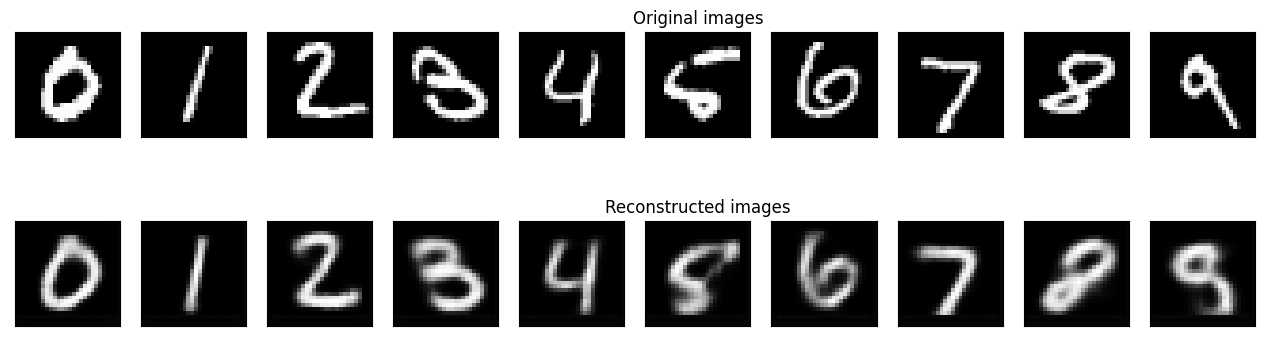


 EPOCH 42/500 	 train loss 138.801 	 val loss 139.308


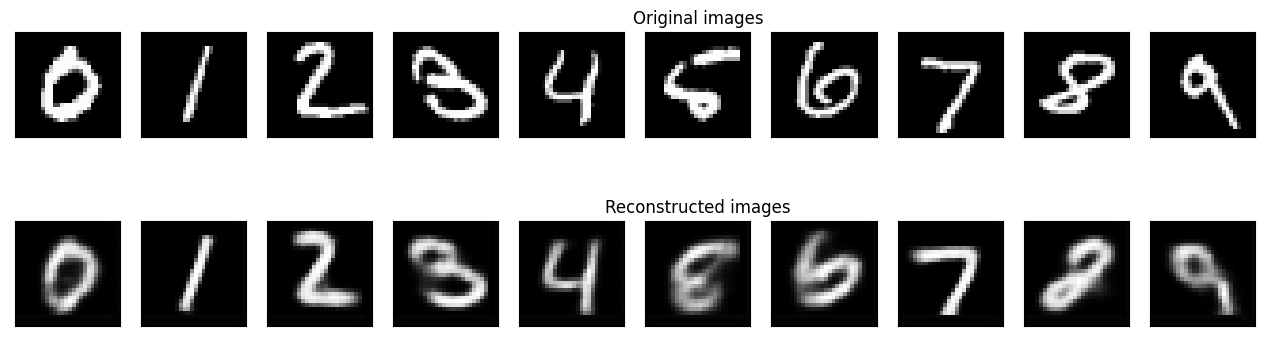


 EPOCH 43/500 	 train loss 138.787 	 val loss 139.798


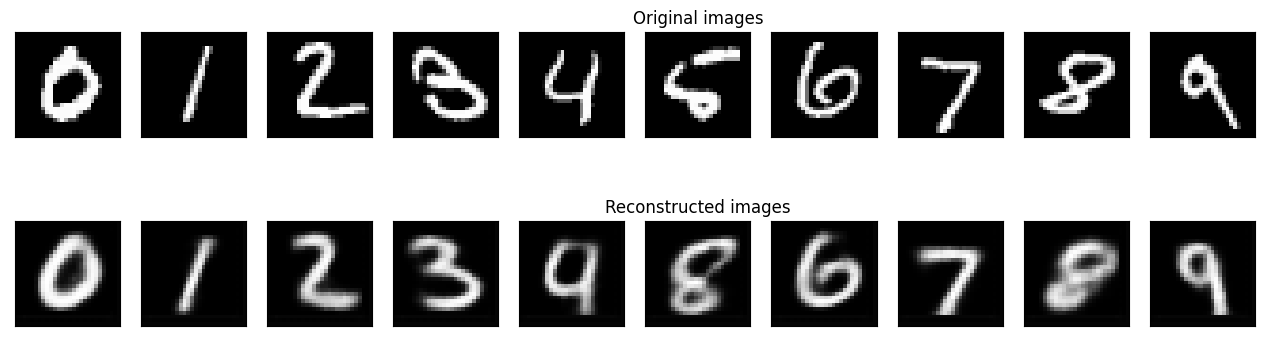


 EPOCH 44/500 	 train loss 138.529 	 val loss 139.749


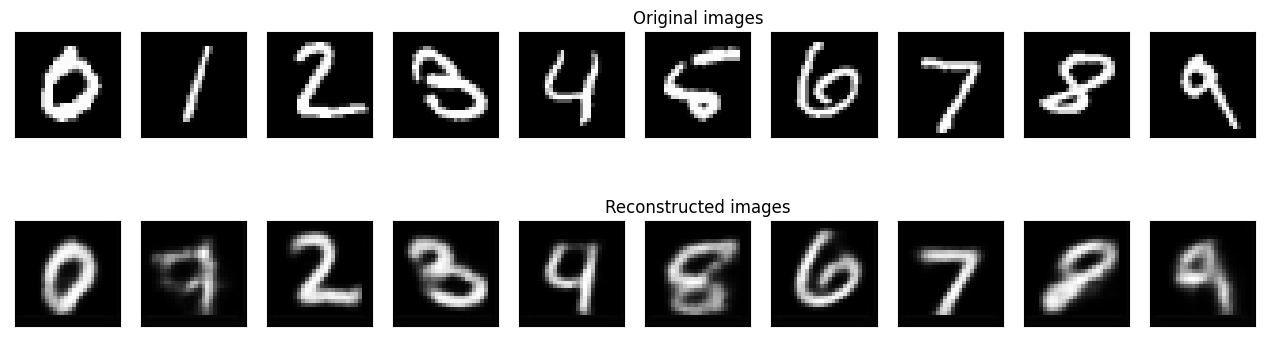


 EPOCH 45/500 	 train loss 138.505 	 val loss 139.249


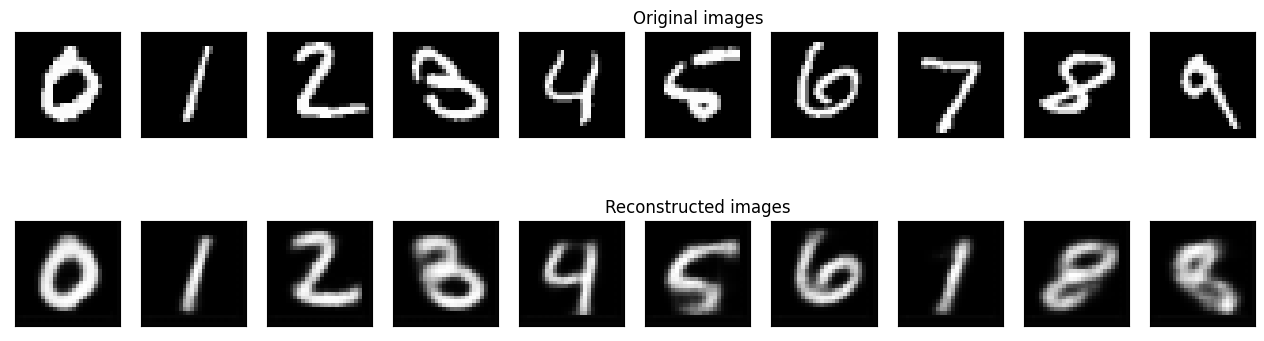


 EPOCH 46/500 	 train loss 138.300 	 val loss 139.140


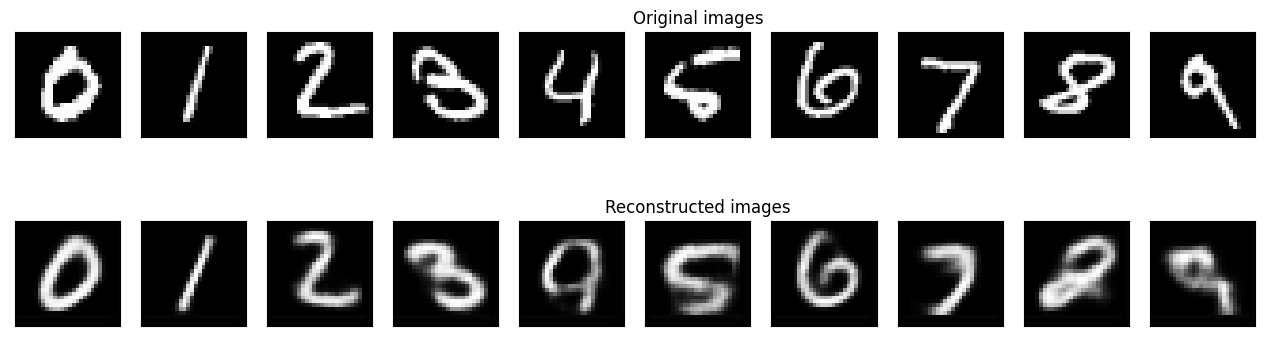


 EPOCH 47/500 	 train loss 138.362 	 val loss 139.215


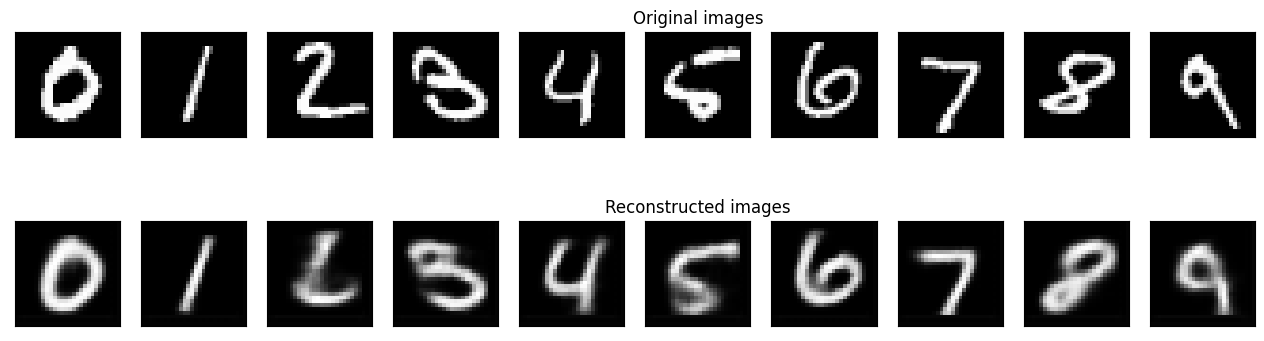


 EPOCH 48/500 	 train loss 138.304 	 val loss 139.184


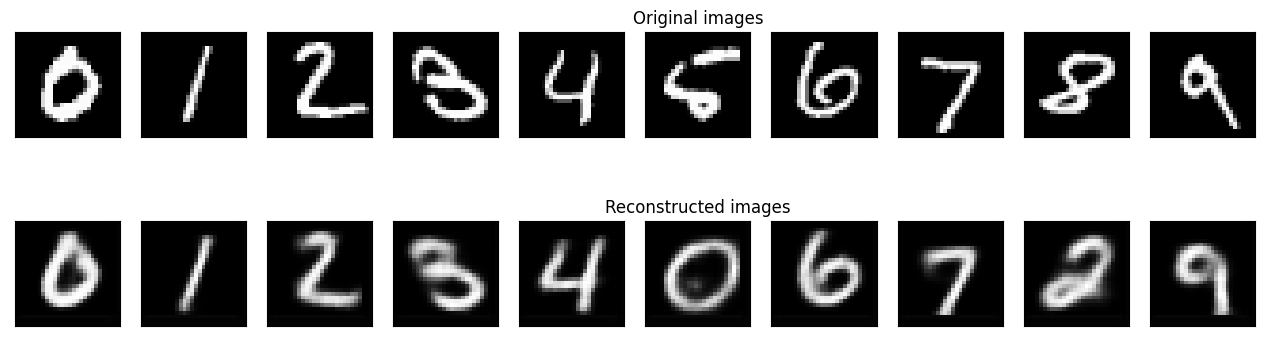


 EPOCH 49/500 	 train loss 138.126 	 val loss 139.037


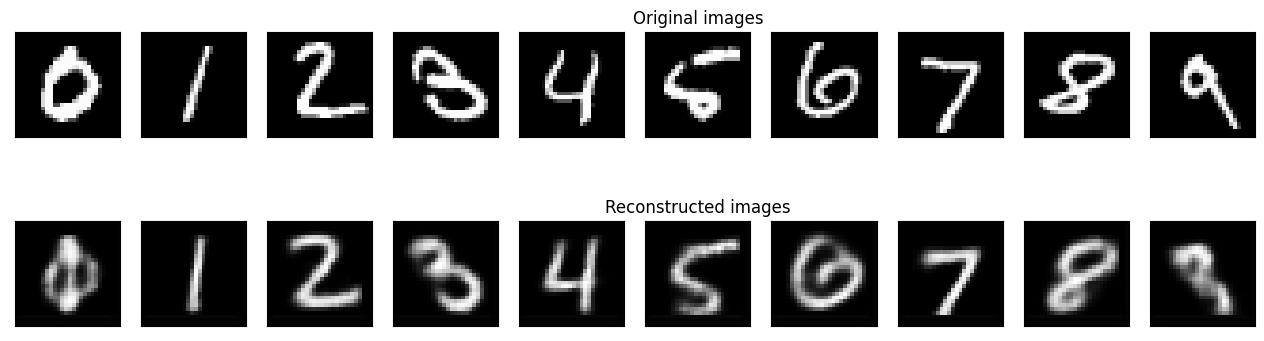


 EPOCH 50/500 	 train loss 138.082 	 val loss 139.247


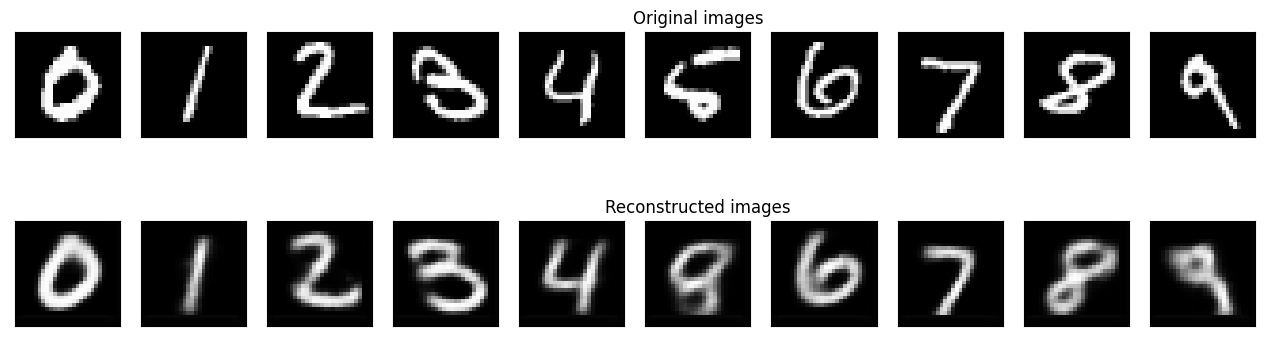

Validation loss is no longer shrinking. Quitting early.


In [52]:
num_epochs = 500
val_losses = []

print("Beginning training")
plot_ae_outputs(vae, n=10)

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    val_losses.append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(vae, n=10)
    if len(val_losses) >= 5 and val_losses[-5] < val_loss:
        print("Validation loss is no longer shrinking. Quitting early.")
        break


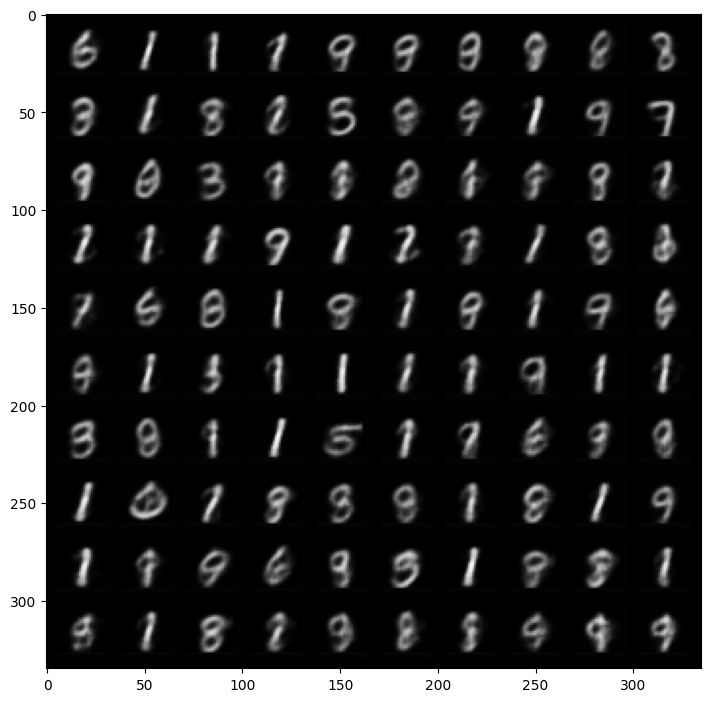

In [60]:
# Random samples from the latent space

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

vae.eval()
with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(100, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data, 10, 5))
    plt.show()


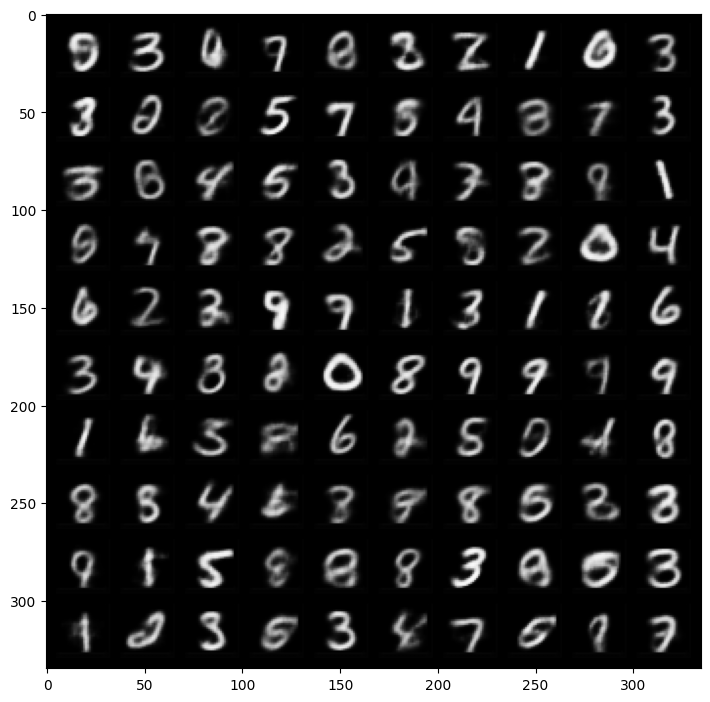

In [56]:
# Average z and std of a bunch of zeroes

zeroes = [
    train_dataset.data[i] for i, label in enumerate(train_dataset.targets) if label == 0
]
zeroes = zeroes[:100]
zeroes = einops.rearrange(torch.stack(zeroes).type(torch.float32), "b h w -> b 1 h w")
zeroes.to(device)
with torch.no_grad():
    vae.eval()
    _, mu, log_var = vae.encoder(zeroes)

    # Average mu and log_var for zeroes in our dataset
    mu_avg = einops.reduce(mu, "b mu -> mu", "mean").cpu()
    log_var_avg = einops.reduce(log_var, "b l -> l", "mean").cpu()
    std_avg = log_var.cpu().mul(0.5).exp_()

    # Generate a bunch of zeroes from latent sampling
    esp = torch.randn(100, latent_dims, dtype=torch.float32)
    z = (esp.mul(std_avg).add(esp)).to(device)

    img_recon = vae.decoder(z)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data, 10, 5))
    plt.show()
